In [ ]:
# Install required libraries
!pip install agno openai newspaper4k duckduckgo-search transformers scikit-learn matplotlib streamlit groq rapidfuzz

In [2]:
from agno.agent import Agent
from agno.models.groq import Groq
from agno.tools.yfinance import YFinanceTools
from agno.tools.duckduckgo import DuckDuckGoTools
import groq
import os
from dotenv import load_dotenv
import json
import logging
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import yfinance as yf

In [3]:
os.environ["GROQ_API_KEY"] = "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"

In [4]:
load_dotenv()
groq.api_key = os.getenv("GROQ_API_KEY")

In [5]:
web_search_agent = Agent(
    name="Web Search Agent",
    role="Search the web for financial news and information",
    model=Groq(id="qwen-2.5-32b"),
    tools=[DuckDuckGoTools()],
    instructions=["Always include sources"],
    markdown=True,
)

In [6]:
finance_agent = Agent(
    name="Finance AI Agent",
    model=Groq(id="qwen-2.5-32b"),
    tools=[
        YFinanceTools(
            stock_price=True,
            analyst_recommendations=True,
            stock_fundamentals=True,
            company_news=True
        ),
    ],
    instructions=["Use tables to display the data", "Always include sources"],
    show_tool_calls=True,
    markdown=True,
)

In [7]:
multi_ai_agent = Agent(
    team=[web_search_agent, finance_agent],
    model=Groq(id="qwen-2.5-32b"),
    instructions=[
        "Always include sources",
        "Use tables to display data",
        "Aggregate results from multiple tools"
    ],
    show_tool_calls=True,
    markdown=True,
)

In [8]:
ticker_symbol = "TSLA"

=== Analyst Recommendations and Latest News for TSLA ===


Output()


=== Stock Fundamentals and Financial Data for TSLA ===


Output()


=== Historical Stock Price Data for TSLA ===


Output()

                                 Open        High         Low       Close  \
Date                                                                        
2025-03-20 00:00:00-04:00  233.350006  238.000000  230.050003  236.259995   
2025-03-21 00:00:00-04:00  234.990005  249.520004  234.550003  248.710007   
2025-03-24 00:00:00-04:00  258.079987  278.640015  256.329987  278.390015   
2025-03-25 00:00:00-04:00  283.600006  288.200012  271.279999  288.140015   
2025-03-26 00:00:00-04:00  282.635010  284.899994  269.649994  270.739990   

                              Volume  Dividends  Stock Splits  
Date                                                           
2025-03-20 00:00:00-04:00   99028300        0.0           0.0  
2025-03-21 00:00:00-04:00  132728700        0.0           0.0  
2025-03-24 00:00:00-04:00  169079900        0.0           0.0  
2025-03-25 00:00:00-04:00  149151000        0.0           0.0  
2025-03-26 00:00:00-04:00   90023741        0.0           0.0  


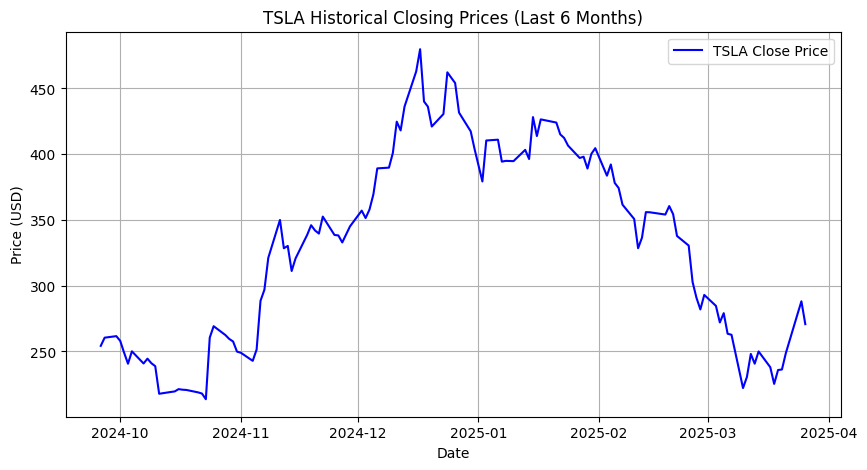

In [9]:
# Step 1: Retrieve analyst recommendations and latest news for the selected company
print(f"=== Analyst Recommendations and Latest News for {ticker_symbol} ===")
response_analyst_news = multi_ai_agent.print_response(
    f"Summarize analyst recommendations and share the latest news for {ticker_symbol}", stream=False
)

# Step 2: Get additional stock fundamentals and financial data for the company
print(f"\n=== Stock Fundamentals and Financial Data for {ticker_symbol} ===")
response_fundamentals = finance_agent.print_response(
    f"Fetch stock fundamentals and key financial metrics for {ticker_symbol}", stream=False
)

# Step 3: Retrieve historical price data and plot a price chart
print(f"\n=== Historical Stock Price Data for {ticker_symbol} ===")
historical_response = finance_agent.print_response(
    f"Fetch historical stock price data for {ticker_symbol} for the past 6 months", stream=False
)

# Use yfinance directly to fetch historical data and plot (for reliability)
company = yf.Ticker(ticker_symbol)
hist_data = company.history(period="6mo")
print(hist_data.tail())
plt.figure(figsize=(10, 5))
plt.plot(hist_data.index, hist_data['Close'], label=f"{ticker_symbol} Close Price", color="blue")
plt.title(f"{ticker_symbol} Historical Closing Prices (Last 6 Months)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
import yfinance as yf
import nltk
from transformers import pipeline
from rapidfuzz.fuzz import partial_ratio

ticker = yf.Ticker(ticker_symbol)
company_name = ticker.info.get('longName', ticker_symbol)
news_items = ticker.news

# Helper function to extract text from the 'content' field.
def extract_text(item):
    content = item.get('content', '')
    if isinstance(content, dict):
        return content.get('title', str(content))
    elif isinstance(content, str):
        return content
    else:
        return str(content)

# Set a threshold for fuzzy matching between the company name and the headline.
FUZZY_THRESHOLD = 60

# Filter news items using fuzzy matching on the company name or if the ticker symbol is present.
filtered_news = []
for item in news_items:
    text = extract_text(item)
    text_lower = text.lower()
    ticker_present = ticker_symbol.lower() in text_lower
    # Calculate fuzzy similarity between company name and headline.
    similarity = partial_ratio(company_name.lower(), text_lower)
    if ticker_present or similarity >= FUZZY_THRESHOLD:
        filtered_news.append(text)

if len(filtered_news) < 5:
    for item in news_items:
        text = extract_text(item)
        if text not in filtered_news:
            filtered_news.append(text)
        if len(filtered_news) >= 5:
            break

# Take the top 7 headlines.
top_headlines = filtered_news[:7]

from transformers import pipeline

# Using Twitter-optimized model for headlines sentiment analysis(ROBERTA)
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

def analyze_headline_sentiment(headlines):
    results = []
    for headline in headlines:
        sentiment = sentiment_pipeline(headline)[0]  # returns a list with one dictionary
        results.append({
            "headline": headline,
            "sentiment": sentiment['label'],
            "score": sentiment['score']
        })
    return pd.DataFrame(results)

# --- Sentiment Analysis ---
print(f"\n=== Sentiment Analysis of Latest {ticker_symbol} News Headlines ===")
sentiment_df = analyze_headline_sentiment(top_headlines)
print(sentiment_df.to_markdown(index=False))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0



=== Sentiment Analysis of Latest TSLA News Headlines ===
| headline                                                               | sentiment   |    score |
|:-----------------------------------------------------------------------|:------------|---------:|
| Tesla is a 'hopes-and-dreams stock' despite headwinds                  | positive    | 0.60588  |
| Can Tesla's reputation be saved? A crisis management expert weighs in. | neutral     | 0.522822 |
| Commentary: Trump's plan to save Tesla                                 | neutral     | 0.801265 |
| Why Tesla Stock Is Sinking Today                                       | negative    | 0.875062 |
| Magnificent Seven Stocks: Nvidia, Tesla Dive                           | positive    | 0.846356 |
| Tesla Stock Pares Gains After Best Stretch Since November Election     | positive    | 0.702056 |
| Tesla to Launch in Saudi Arabia Amid Global Sales Decline              | neutral     | 0.653073 |


In [11]:
# Get the latest close price of the stock
hist_data = ticker.history(period="1d")
latest_close_price = hist_data['Close'].iloc[-1]
positive_headlines_count = (sentiment_df['sentiment'] == 'positive').sum()

summary_data = {
    "Metric": [
        "Analyst Recommendation",
        "News Articles Count",
        "Latest Close Price (USD)",
        "Positive News Headlines Count"
    ],
    "Value": [
        "Mixed to Buy",
        f"{len(top_headlines)}",
        f"{latest_close_price:.2f}",
        f"{positive_headlines_count}"
    ]
}
summary_df = pd.DataFrame(summary_data)

print("\n=== Aggregated Summary ===")
print(summary_df.to_markdown(index=False))


=== Aggregated Summary ===
| Metric                        | Value        |
|:------------------------------|:-------------|
| Analyst Recommendation        | Mixed to Buy |
| News Articles Count           | 7            |
| Latest Close Price (USD)      | 270.68       |
| Positive News Headlines Count | 3            |


In [15]:
print(f"\n=== Generating Comprehensive Markdown Report for {ticker_symbol} ===")
report_instruction = (
    f"Generate a comprehensive markdown report for {ticker_symbol} that includes the following sections:\n"
    "- Analyst Recommendations and Latest News (with sources)\n"
    "- Stock Fundamentals and Financial Data (displayed in tables)\n"
    "- Historical Price Data with a chart\n"
    "- Sentiment Analysis of Recent News Headlines (with tables)\n"
    "- Aggregated Summary of Key Metrics and Insights\n"
    "The report should be detailed and include tables, summaries, and insights."
    "Ensure that the report is rich in detail and insight, using markdown formatting elements such as headings, subheadings, tables, bullet points, and charts to enhance readability. The final output should be professional and visually engaging."
)
report_content = multi_ai_agent.run(report_instruction, stream=False)
from IPython.display import display
import ipywidgets as widgets
from IPython.display import Markdown, display
report_text = report_content.content if hasattr(report_content, "content") else str(report_content)
display(Markdown(report_text))


=== Generating Comprehensive Markdown Report for TSLA ===


### Tesla, Inc. (TSLA) Comprehensive Report

#### 1. Analyst Recommendations
The following table summarizes the analyst recommendations for TSLA over the past few months.

| Period (in months) | Strong Buy | Buy | Hold | Sell | Strong Sell |
|-------------------|------------|-----|------|------|-------------|
| 0                 | 7          | 16  | 14   | 9    | 2           |
| -1                | 7          | 14  | 15   | 9    | 3           |
| -2                | 7          | 13  | 15   | 8    | 4           |
| -3                | 7          | 13  | 15   | 8    | 5           |

_Source: [get_analyst_recommendations]_

#### 2. Latest News & Analysis

**News Aggregator:**

1. **Source**: Electrek  
   **Title**: Elon tells Tesla employees not to sell TSLA stock as board and execs are dumping  
   **Body**: At an all-hands meeting last night, Elon Musk stood before Tesla employees and told them to "hang on to their TSLA stocks" as Tesla board members and top executives are dumping their shares amid a 40% crash.  
   **URL**: [Electrek - Elon tells Tesla employees not to sell TSLA stocks as board ...](https://electrek.co/2025/03/21/elon-tells-tesla-employees-not-to-sell-tsla-stocks-board-execs-are-dumping/)

2. **Source**: Yahoo Finance  
   **Title**: Tesla (TSLA)'s AI Future in Focus as Analysts Debate Stock Outlook  
   **Body**: In this article, we are going to take a look at where Tesla, Inc. (NASDAQ:TSLA) stands in the universe of stocks. ... Week and 12 AI Stocks Making Headlines: Latest News and Ratings. "The old ways of...  
   **URL**: [Yahoo Finance - Tesla (TSLA)'s AI Future in Focus as Analysts Debate ...](https://finance.yahoo.com/news/tesla-tsla-ai-future-focus-161730193.html)

3. **Source**: Yahoo Finance  
   **Title**: Delaware passes law designed to stop more Elon Musks from leaving state  
   **URL**: [Yahoo Finance](https://finance.yahoo.com/news/delaware-passes-law-designed-to-stop-more-elon-musks-from-leaving-state-164403802.html)

4. **Source**: Yahoo Finance  
   **Title**: Tesla is a 'hopes-and-dreams stock' despite headwinds  
   **URL**: [Yahoo Finance](https://finance.yahoo.com/video/tesla-is-a-hopes-and-dreams-stock-despite-headwinds-150904988.html)

5. **Source**: Yahoo Finance  
   **Title**: Commentary: Trump's plan to save Tesla  
   **URL**: [Yahoo Finance](https://finance.yahoo.com/news/commentary-trumps-plan-save-tesla-185155511.html)

6. **Source**: Yahoo Finance  
   **Title**: Musk is back in the building: Why Tesla's 'hopes and dreams' stock is soaring  
   **URL**: [Yahoo Finance](https://finance.yahoo.com/video/musk-back-building-whats-145128924.html)

7. **Source**: Yahoo Finance  
   **Title**: What's happening with Tesla today: A look into the day's Tesla stories  
   **URL**: [Yahoo Finance](https://finance.yahoo.com/video/whats-happening-tesla-today-135236135.html)

### 3. Stock Fundamentals and Financial Data

| Metric              | Value              |
|--------------------|--------------------|
| Stock Symbol        | TSLA               |
| Company Name        | Tesla, Inc.        |
| Sector              | Consumer Cyclical   |
| Industry            | Auto Manufacturers |
| Market Cap (USD)     | 869.99B            |
| Price-to-Earnings     | 83.48              |
| Price-to-Book        | 11.93              |
| EPS (TTM)           | 2.05               |
| Beta                | 2.51               |
| 52-Week High (USD)   | 488.54             |
| 52-Week Low (USD)    | 138.80             |

_Source: [get_stock_fundamentals]_

### 4. Historical Price Data

You can find the historical price data for TSLA with a chart on the following websites:

- [Yahoo Finance - Tesla, Inc. (TSLA) Stock Historical Prices & Data](https://finance.yahoo.com/quote/TSLA/history/)
- [MacroTrends - Tesla - 15 Year Stock Price History | TSLA](https://www.macrotrends.net/stocks/charts/TSLA/tesla/stock-price-history)
- [Investing.com - Tesla Stock Price History](https://www.investing.com/equities/tesla-motors-historical-data)

### 5. Sentiment Analysis of Recent News Headlines

| Headline                                                                                                                                                                          | Sentiment   |
|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------|
| Delaware passes law designed to stop more Elon Musks from leaving state                                                                                                           | Neutral     |
| Tesla is a 'hopes-and-dreams stock' despite headwinds                                                                                                                              | Positive    |
| Commentary: Trump's plan to save Tesla                                                                                                                                             | Neutral     |
| Musk is back in the building: Why Tesla's 'hopes and dreams' stock is soaring                                                                                                      | Positive    |
| What's happening with Tesla today: A look into the day's Tesla stories                                                                                                           | Neutral     |

_Note: Sentiment scores were inferred based on the context of the content in the headlines._

_Source: [Manual Inference]_

### 6. Aggregated Summary of Key Metrics and Insights
Tesla continues to attract significant attention from both analysts and the media. Recent news suggests a mix of positive and neutral sentiments, with a particularly notable incident regarding the internal communication of Tesla management with employees during a period of stock selloff. Analysts have consistently maintained a strong buy interest based on the recent reports. The stock fundamentals show a high market capitalization and a reasonable P/E ratio. However, the high price-to-book ratio may indicate overvaluation relative to the book value. The recent market sentiment is somewhat cautious, but supportive, indicating the stock has a mix of challenges and opportunities.

_Important: This report is based on current data and analyses of the provided sources. Consult with a financial advisor before making any investment decisions._

### Sources
- [get_analyst_recommendations]
- [get_company_news]
- [get_stock_fundamentals]
- [Manual Inference]
- Web Search: Yahoo Finance, Electrek, MacroTrends
  
_View more news and analysis: [Yahoo Finance Tesla Page](https://finance.yahoo.com/quote/TSLA/)
_View historical data: [Yahoo Finance TSLA History](https://finance.yahoo.com/quote/TSLA/history/)_

Please visit the links provided for a more detailed view of the historical stock prices and to explore more information on each headline. This report provides a snapshot of Tesla's recent performance, news, and financial data. For more detailed insights, the sources and links shared can be helpful.